In [ ]:
!git clone https://github.com/yuanzhi-zhu/DiffPIR.git


Cloning into 'DiffPIR'...
remote: Enumerating objects: 323, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 323 (delta 42), reused 87 (delta 31), pack-reused 212
Receiving objects: 100% (323/323), 92.12 MiB | 26.94 MiB/s, done.
Resolving deltas: 100% (143/143), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/DiffPIR/


/content/DiffPIR


In [ ]:
## install package

! pip install hdf5storage
! pip install lpips


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [ ]:
import os.path
import cv2
import logging

import numpy as np
import torch
import torch.nn.functional as F
from datetime import datetime
from collections import OrderedDict
import hdf5storage

from utils import utils_model
from utils import utils_logger
from utils import utils_sisr as sr
from utils import utils_image as util
from utils.utils_deblur import MotionBlurOperator, GaussialBlurOperator
from scipy import ndimage

# from guided_diffusion import dist_util
from guided_diffusion.script_util import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    create_model_and_diffusion,
    args_to_dict,
)

# Experiment debluring

## Original paper

In [ ]:
## set up paramters for PnP algorithm

noise_level_img         = 12.75/255.0           # set AWGN noise level for LR image, default: 0
noise_level_model       = noise_level_img       # set noise level of model, default: 0
model_name              = 'diffusion_ffhq_10m'  # diffusion_ffhq_10m, 256x256_diffusion_uncond; set diffusino model
testset_name            = 'demo_test'            # set testing set,  'imagenet_val' | 'ffhq_val'
num_train_timesteps     = 1000
iter_num                = 100                # set number of iterations
iter_num_U              = 1                 # set number of inner iterations, default: 1
skip                    = num_train_timesteps//iter_num     # skip interval

show_img                = False             # default: False
save_L                  = True             # save LR image
save_E                  = True              # save estimated image
save_LEH                = False             # save zoomed LR, E and H images
save_progressive        = False             # save generation process
border                  = 0

sigma                   = max(0.001,noise_level_img)  # noise level associated with condition y
lambda_                 = 8               # key parameter lambda
sub_1_analytic          = True              # use analytical solution

log_process             = False
ddim_sample             = False             # sampling method
model_output_type       = 'pred_xstart'     # model output type: pred_x_prev; pred_xstart; epsilon; score
generate_mode           = 'DiffPIR'         # DiffPIR; DPS; vanilla
skip_type               = 'quad'            # uniform, quad
eta                     = 0.0               # eta for ddim sampling
zeta                    = 0.1
guidance_scale          = 1.0

calc_LPIPS              = True
use_DIY_kernel          = True
blur_mode               = 'Gaussian'          # Gaussian; motion
kernel_size             = 61
kernel_std              = 3.0 if blur_mode == 'Gaussian' else 0.5

sf                      = 1
task_current            = 'deblur'
n_channels              = 3                 # fixed
cwd                     = ''
model_zoo               = os.path.join(cwd, 'model_zoo')    # fixed
testsets                = os.path.join(cwd, 'testsets')     # fixed
results                 = os.path.join(cwd, 'results')      # fixed
result_name             = f'{testset_name}_{task_current}_{generate_mode}_{model_name}_sigma{noise_level_img}_NFE{iter_num}_eta{eta}_zeta{zeta}_lambda{lambda_}_blurmode{blur_mode}'
model_path              = '/content/drive/MyDrive/tien/models/ffhq_10m.pt'
device                  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

# noise schedule
beta_start              = 0.1 / 1000
beta_end                = 20 / 1000
betas                   = np.linspace(beta_start, beta_end, num_train_timesteps, dtype=np.float32)
betas                   = torch.from_numpy(betas).to(device)
alphas                  = 1.0 - betas
alphas_cumprod          = np.cumprod(alphas.cpu(), axis=0)
sqrt_alphas_cumprod     = torch.sqrt(alphas_cumprod)
sqrt_1m_alphas_cumprod  = torch.sqrt(1. - alphas_cumprod)
reduced_alpha_cumprod   = torch.div(sqrt_1m_alphas_cumprod, sqrt_alphas_cumprod)        # equivalent noise sigma on image

noise_model_t           = utils_model.find_nearest(reduced_alpha_cumprod, 2 * noise_level_model)
noise_model_t           = 0

noise_inti_img          = 50 / 255
t_start                 = utils_model.find_nearest(reduced_alpha_cumprod, 2 * noise_inti_img) # start timestep of the diffusion process
t_start                 = num_train_timesteps - 1

In [ ]:
# ----------------------------------------
# L_path, E_path, H_path
# ----------------------------------------

L_path = os.path.join(testsets, testset_name) # L_path, for Low-quality images
E_path = os.path.join(results, result_name)   # E_path, for Estimated images
util.mkdir(E_path)

logger_name = result_name
utils_logger.logger_info(logger_name, log_path=os.path.join(E_path, logger_name+'.log'))
logger = logging.getLogger(logger_name)

LogHandlers exists!


In [ ]:
device

device(type='cuda')

In [ ]:
model_path

'/content/drive/MyDrive/tien/models/ffhq_10m.pt'

In [ ]:
## create at diffusion model

model_config = dict(
            model_path=model_path,
            num_channels=128,
            num_res_blocks=1,
            attention_resolutions="16",
        ) if model_name == 'diffusion_ffhq_10m' \
        else dict(
            model_path=model_path,
            num_channels=256,
            num_res_blocks=2,
            attention_resolutions="8,16,32",
        )
args = utils_model.create_argparser(model_config).parse_args([])
model, diffusion = create_model_and_diffusion(
        **args_to_dict(args, model_and_diffusion_defaults().keys()))
    # model.load_state_dict(
    #     dist_util.load_state_dict(args.model_path, map_location="cpu")
    # )
model.load_state_dict(torch.load(args.model_path, map_location="cpu"))
model.eval()

if generate_mode != 'DPS_y0':
        # for DPS_yt, we can avoid backward through the model
    for k, v in model.named_parameters():
            v.requires_grad = False
model = model.to(device)

logger.info('model_name:{}, image sigma:{:.3f}, model sigma:{:.3f}'.format(model_name, noise_level_img, noise_level_model))
logger.info('eta:{:.3f}, zeta:{:.3f}, lambda:{:.3f}, guidance_scale:{:.2f} '.format(eta, zeta, lambda_, guidance_scale))
logger.info('start step:{}, skip_type:{}, skip interval:{}, skipstep analytic steps:{}'.format(t_start, skip_type, skip, noise_model_t))
logger.info('use_DIY_kernel:{}, blur mode:{}'.format(use_DIY_kernel, blur_mode))
logger.info('Model path: {:s}'.format(model_path))
logger.info(L_path)
L_paths = util.get_image_paths(L_path)

import ssl

if calc_LPIPS:
    import lpips

    # Disable SSL certificate verification
    ssl._create_default_https_context = ssl._create_unverified_context

    loss_fn_vgg = lpips.LPIPS(net='vgg').to(device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 67.6MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


In [ ]:
## kernel predefine

for idx, img in enumerate(L_paths):
    if use_DIY_kernel:
        np.random.seed(seed=idx*10)  # for reproducibility of blur kernel for each image
        if blur_mode == 'Gaussian':
            kernel_std_i = kernel_std * np.abs(np.random.rand()*2+1)
            kernel = GaussialBlurOperator(kernel_size=kernel_size, intensity=kernel_std_i, device=device)
        elif blur_mode == 'motion':
            kernel = MotionBlurOperator(kernel_size=kernel_size, intensity=kernel_std, device=device)
        k_tensor = kernel.get_kernel().to(device, dtype=torch.float)
        k = k_tensor.clone().detach().cpu().numpy()       #[0,1]
        k = np.squeeze(k)
        k = np.squeeze(k)
    else:
        k_index = 0
        kernels = hdf5storage.loadmat(os.path.join(cwd, 'kernels', 'Levin09.mat'))['kernels']
        k = kernels[0, k_index].astype(np.float32)
    img_name, ext = os.path.splitext(os.path.basename(img))
    util.imsave(k*255.*200, os.path.join(E_path, f'motion_kernel_{img_name}{ext}'))
    #np.save(os.path.join(E_path, 'motion_kernel.npy'), k)
    k_4d = torch.from_numpy(k).to(device)
    k_4d = torch.einsum('ab,cd->abcd',torch.eye(3).to(device),k_4d)

    model_out_type = model_output_type

In [ ]:
## Load image

img_H = util.imread_uint("/content/DiffPIR/testsets/demo_test/69037.png", n_channels=n_channels)
img_H = util.modcrop(img_H, 8)
img_H.shape

(256, 256, 3)

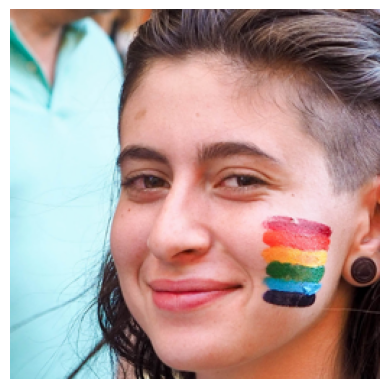

In [ ]:
import matplotlib.pyplot as plt
import torch

# Display the image using matplotlib
plt.imshow(img_H)
plt.axis('off')  # Hide axis
plt.show()

In [ ]:
## Degrade image

img_L = ndimage.convolve(img_H, np.expand_dims(k, axis=2), mode='wrap')
util.imshow(img_H) if show_img else None
img_L = util.uint2single(img_L)

np.random.seed(seed=0)  # for reproducibility
img_L = img_L * 2 - 1
img_L += np.random.normal(0, noise_level_img * 2, img_L.shape) # add AWGN
img_L = img_L / 2 + 0.5

y = util.single2tensor4(img_L).to(device)

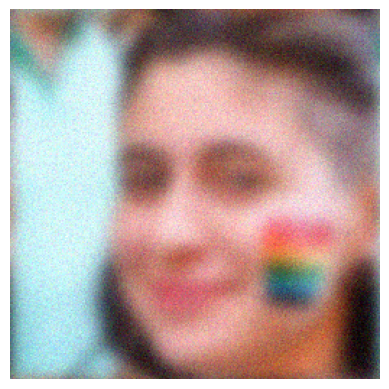

In [ ]:
import matplotlib.pyplot as plt
import torch

# Display the image using matplotlib
plt.imshow(img_L)
plt.axis('off')  # Hide axis
plt.show()

In [ ]:
# Calculate sigma, sigma_ks, rho (follow by t, pre-defined)
sigmas = []
sigma_ks = []
rhos = []
for i in range(num_train_timesteps):
    sigmas.append(reduced_alpha_cumprod[num_train_timesteps-1-i])
    if model_out_type == 'pred_xstart' and generate_mode == 'DiffPIR':
        sigma_ks.append((sqrt_1m_alphas_cumprod[i]/sqrt_alphas_cumprod[i]))
                #elif model_out_type == 'pred_x_prev':
    else:
        sigma_ks.append(torch.sqrt(betas[i]/alphas[i]))
    rhos.append(lambda_*(sigma**2)/(sigma_ks[i]**2))
rhos, sigmas, sigma_ks = torch.tensor(rhos).to(device), torch.tensor(sigmas).to(device), torch.tensor(sigma_ks).to(device)


t_y = utils_model.find_nearest(reduced_alpha_cumprod, 2 * noise_level_img)
sqrt_alpha_effective = sqrt_alphas_cumprod[t_start] / sqrt_alphas_cumprod[t_y]
x = sqrt_alpha_effective * (2*y-1) + torch.sqrt(sqrt_1m_alphas_cumprod[t_start]**2 - \
sqrt_alpha_effective**2 * sqrt_1m_alphas_cumprod[t_y]**2) * torch.randn_like(y)
# x = torch.randn_like(y)

k_tensor = util.single2tensor4(np.expand_dims(k, 2)).to(device)

In [ ]:
progress_img = []
# create sequence of timestep for sampling
if skip_type == 'uniform':
    seq = [i*skip for i in range(iter_num)]
    if skip > 1:
        seq.append(num_train_timesteps-1)
elif skip_type == "quad":
    seq = np.sqrt(np.linspace(0, num_train_timesteps**2, iter_num))
    seq = [int(s) for s in list(seq)]
    seq[-1] = seq[-1] - 1
progress_seq = seq[::max(len(seq)//10,1)]
if progress_seq[-1] != seq[-1]:
    progress_seq.append(seq[-1])

In [ ]:
FB, FBC, F2B, FBFy = sr.pre_calculate(y, k_tensor, sf)

In [ ]:
## PnP algorithm


x = sqrt_alpha_effective * (2*y-1) + torch.sqrt(sqrt_1m_alphas_cumprod[t_start]**2 - \
                    sqrt_alpha_effective**2 * sqrt_1m_alphas_cumprod[t_y]**2) * torch.randn_like(y)

for i in range(len(seq)):
    curr_sigma = sigmas[seq[i]].cpu().numpy()
    # time step associated with the noise level sigmas[i]
    t_i = utils_model.find_nearest(reduced_alpha_cumprod,curr_sigma)

    x0 = utils_model.model_fn(x, noise_level=curr_sigma*255, model_out_type=model_out_type, \
                               model_diffusion=model, diffusion=diffusion, ddim_sample=ddim_sample, alphas_cumprod=alphas_cumprod)

    if seq[i] != seq[-1]:
       tau = rhos[t_i].float().repeat(1, 1, 1, 1)
       x0_p = x0 / 2 + 0.5
       x0_p = sr.data_solution(x0_p.float(), FB, FBC, F2B, FBFy, tau, sf)
       x0_p = x0_p * 2 - 1
       # effective x0
       x0 = x0 + guidance_scale * (x0_p-x0)
       t_im1 = utils_model.find_nearest(reduced_alpha_cumprod,sigmas[seq[i+1]].cpu().numpy())
       eps = (x - sqrt_alphas_cumprod[t_i] * x0) / sqrt_1m_alphas_cumprod[t_i]
       eta_sigma = eta * sqrt_1m_alphas_cumprod[t_im1] / sqrt_1m_alphas_cumprod[t_i] * torch.sqrt(betas[t_i])
       x = sqrt_alphas_cumprod[t_im1] * x0 + np.sqrt(1-zeta) * (torch.sqrt(sqrt_1m_alphas_cumprod[t_im1]**2 - eta_sigma**2) * eps \
            + eta_sigma * torch.randn_like(x)) + np.sqrt(zeta) * sqrt_1m_alphas_cumprod[t_im1] * torch.randn_like(x)


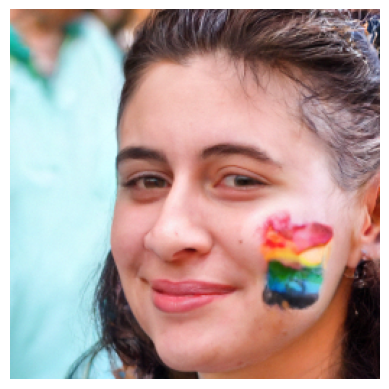

In [ ]:
import matplotlib.pyplot as plt
plt.imshow((x[0]/2+0.5).permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

## Experiment with different predefine blur kernel

In [ ]:
kernel = MotionBlurOperator(kernel_size=kernel_size, intensity=0.7, device=device)

k_tensor = kernel.get_kernel().to(device, dtype=torch.float)
k = k_tensor.clone().detach().cpu().numpy()       #[0,1]
k = np.squeeze(k)
k = np.squeeze(k)

In [ ]:
img_L_change = ndimage.convolve(img_H, np.expand_dims(k, axis=2), mode='wrap')
util.imshow(img_H) if show_img else None
img_L_change = util.uint2single(img_L_change)

np.random.seed(seed=0)  # for reproducibility
img_L_change = img_L_change * 2 - 1
img_L_change += np.random.normal(0, 0.09 * 2, img_L_change.shape) # add AWGN
img_L_change = img_L_change / 2 + 0.5

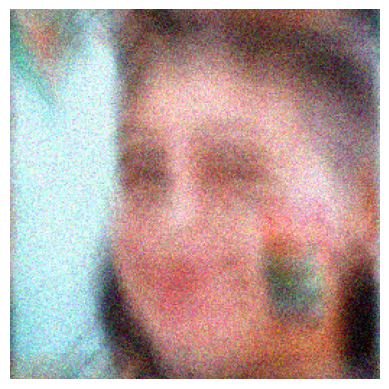

In [ ]:
import matplotlib.pyplot as plt
import torch

# Display the image using matplotlib
plt.imshow(img_L_change)
plt.axis('off')  # Hide axis
plt.show()

In [ ]:
y = util.single2tensor4(img_L).to(device)
k_tensor = util.single2tensor4(np.expand_dims(k, 2)).to(device)
FB, FBC, F2B, FBFy = sr.pre_calculate(y, k_tensor, sf)

In [ ]:
## PnP algorithm

x = sqrt_alpha_effective * (2*y-1) + torch.sqrt(sqrt_1m_alphas_cumprod[t_start]**2 - \
                    sqrt_alpha_effective**2 * sqrt_1m_alphas_cumprod[t_y]**2) * torch.randn_like(y)

for i in range(len(seq)):
    curr_sigma = sigmas[seq[i]].cpu().numpy()
    # time step associated with the noise level sigmas[i]
    t_i = utils_model.find_nearest(reduced_alpha_cumprod,curr_sigma)

    x0 = utils_model.model_fn(x, noise_level=curr_sigma*255, model_out_type=model_out_type, \
                               model_diffusion=model, diffusion=diffusion, ddim_sample=ddim_sample, alphas_cumprod=alphas_cumprod)

    if seq[i] != seq[-1]:
       tau = rhos[t_i].float().repeat(1, 1, 1, 1)
       x0_p = x0 / 2 + 0.5
       x0_p = sr.data_solution(x0_p.float(), FB, FBC, F2B, FBFy, tau, sf)
       x0_p = x0_p * 2 - 1
       # effective x0
       x0 = x0 + guidance_scale * (x0_p-x0)
       t_im1 = utils_model.find_nearest(reduced_alpha_cumprod,sigmas[seq[i+1]].cpu().numpy())
       eps = (x - sqrt_alphas_cumprod[t_i] * x0) / sqrt_1m_alphas_cumprod[t_i]
       eta_sigma = eta * sqrt_1m_alphas_cumprod[t_im1] / sqrt_1m_alphas_cumprod[t_i] * torch.sqrt(betas[t_i])
       x = sqrt_alphas_cumprod[t_im1] * x0 + np.sqrt(1-zeta) * (torch.sqrt(sqrt_1m_alphas_cumprod[t_im1]**2 - eta_sigma**2) * eps \
            + eta_sigma * torch.randn_like(x)) + np.sqrt(zeta) * sqrt_1m_alphas_cumprod[t_im1] * torch.randn_like(x)


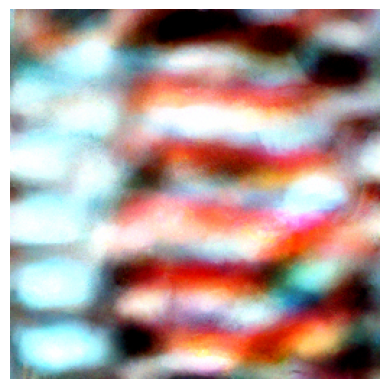

In [ ]:
import matplotlib.pyplot as plt
plt.imshow((x[0]/2+0.5).permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

In [ ]:
kernel_std_i = 5 * np.abs(np.random.rand()*2+1)
kernel = GaussialBlurOperator(kernel_size=kernel_size, intensity=kernel_std_i, device=device)

k_tensor = kernel.get_kernel().to(device, dtype=torch.float)
k = k_tensor.clone().detach().cpu().numpy()       #[0,1]
k = np.squeeze(k)
k = np.squeeze(k)

In [ ]:
img_L_change = ndimage.convolve(img_H, np.expand_dims(k, axis=2), mode='wrap')
util.imshow(img_H) if show_img else None
img_L_change = util.uint2single(img_L_change)

np.random.seed(seed=0)  # for reproducibility
img_L_change = img_L_change * 2 - 1
img_L_change += np.random.normal(0, 0.09 * 2, img_L_change.shape) # add AWGN
img_L_change = img_L_change / 2 + 0.5

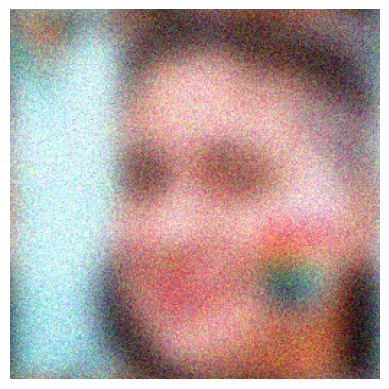

In [ ]:
import matplotlib.pyplot as plt
import torch

# Display the image using matplotlib
plt.imshow(img_L_change)
plt.axis('off')  # Hide axis
plt.show()

In [ ]:
y = util.single2tensor4(img_L).to(device)
k_tensor = util.single2tensor4(np.expand_dims(k, 2)).to(device)
FB, FBC, F2B, FBFy = sr.pre_calculate(y, k_tensor, sf)

In [ ]:
## PnP algorithm
y = util.single2tensor4(img_L).to(device)

x = sqrt_alpha_effective * (2*y-1) + torch.sqrt(sqrt_1m_alphas_cumprod[t_start]**2 - \
                    sqrt_alpha_effective**2 * sqrt_1m_alphas_cumprod[t_y]**2) * torch.randn_like(y)

for i in range(len(seq)):
    curr_sigma = sigmas[seq[i]].cpu().numpy()
    # time step associated with the noise level sigmas[i]
    t_i = utils_model.find_nearest(reduced_alpha_cumprod,curr_sigma)

    x0 = utils_model.model_fn(x, noise_level=curr_sigma*255, model_out_type=model_out_type, \
                               model_diffusion=model, diffusion=diffusion, ddim_sample=ddim_sample, alphas_cumprod=alphas_cumprod)

    if seq[i] != seq[-1]:
       tau = rhos[t_i].float().repeat(1, 1, 1, 1)
       x0_p = x0 / 2 + 0.5
       x0_p = sr.data_solution(x0_p.float(), FB, FBC, F2B, FBFy, tau, sf)
       x0_p = x0_p * 2 - 1
       # effective x0
       x0 = x0 + guidance_scale * (x0_p-x0)
       t_im1 = utils_model.find_nearest(reduced_alpha_cumprod,sigmas[seq[i+1]].cpu().numpy())
       eps = (x - sqrt_alphas_cumprod[t_i] * x0) / sqrt_1m_alphas_cumprod[t_i]
       eta_sigma = eta * sqrt_1m_alphas_cumprod[t_im1] / sqrt_1m_alphas_cumprod[t_i] * torch.sqrt(betas[t_i])
       x = sqrt_alphas_cumprod[t_im1] * x0 + np.sqrt(1-zeta) * (torch.sqrt(sqrt_1m_alphas_cumprod[t_im1]**2 - eta_sigma**2) * eps \
            + eta_sigma * torch.randn_like(x)) + np.sqrt(zeta) * sqrt_1m_alphas_cumprod[t_im1] * torch.randn_like(x)


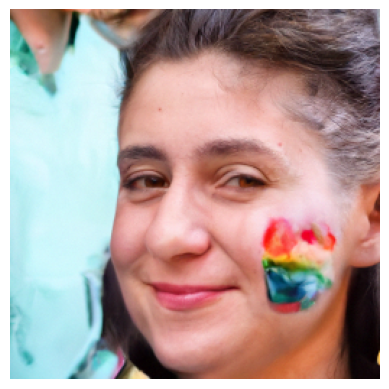

In [ ]:
import matplotlib.pyplot as plt
plt.imshow((x[0]/2+0.5).permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

## Experiment with different diffusion model


In [28]:
## create another diffusion model

model_config = dict(
            model_path='/content/drive/MyDrive/tien/models/metface_p2.pt',
            num_channels=128,
            num_res_blocks=1,
            attention_resolutions="16",
        )
args = utils_model.create_argparser(model_config).parse_args([])
model, diffusion = create_model_and_diffusion(
        **args_to_dict(args, model_and_diffusion_defaults().keys()))
    # model.load_state_dict(
    #     dist_util.load_state_dict(args.model_path, map_location="cpu")
    # )
model.load_state_dict(torch.load(args.model_path, map_location="cpu"))
model.eval()

if generate_mode != 'DPS_y0':
        # for DPS_yt, we can avoid backward through the model
    for k, v in model.named_parameters():
            v.requires_grad = False
model = model.to(device)

logger.info('model_name:{}, image sigma:{:.3f}, model sigma:{:.3f}'.format(model_name, noise_level_img, noise_level_model))
logger.info('eta:{:.3f}, zeta:{:.3f}, lambda:{:.3f}, guidance_scale:{:.2f} '.format(eta, zeta, lambda_, guidance_scale))
logger.info('start step:{}, skip_type:{}, skip interval:{}, skipstep analytic steps:{}'.format(t_start, skip_type, skip, noise_model_t))
logger.info('use_DIY_kernel:{}, blur mode:{}'.format(use_DIY_kernel, blur_mode))
logger.info('Model path: {:s}'.format(model_path))
logger.info(L_path)
L_paths = util.get_image_paths(L_path)

import ssl

if calc_LPIPS:
    import lpips

    # Disable SSL certificate verification
    ssl._create_default_https_context = ssl._create_unverified_context

    loss_fn_vgg = lpips.LPIPS(net='vgg').to(device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


In [29]:
## kernel predefine

for idx, img in enumerate(L_paths):
    if use_DIY_kernel:
        np.random.seed(seed=idx*10)  # for reproducibility of blur kernel for each image
        if blur_mode == 'Gaussian':
            kernel_std_i = kernel_std * np.abs(np.random.rand()*2+1)
            kernel = GaussialBlurOperator(kernel_size=kernel_size, intensity=kernel_std_i, device=device)
        elif blur_mode == 'motion':
            kernel = MotionBlurOperator(kernel_size=kernel_size, intensity=kernel_std, device=device)
        k_tensor = kernel.get_kernel().to(device, dtype=torch.float)
        k = k_tensor.clone().detach().cpu().numpy()       #[0,1]
        k = np.squeeze(k)
        k = np.squeeze(k)
    else:
        k_index = 0
        kernels = hdf5storage.loadmat(os.path.join(cwd, 'kernels', 'Levin09.mat'))['kernels']
        k = kernels[0, k_index].astype(np.float32)
    img_name, ext = os.path.splitext(os.path.basename(img))
    util.imsave(k*255.*200, os.path.join(E_path, f'motion_kernel_{img_name}{ext}'))
    #np.save(os.path.join(E_path, 'motion_kernel.npy'), k)
    k_4d = torch.from_numpy(k).to(device)
    k_4d = torch.einsum('ab,cd->abcd',torch.eye(3).to(device),k_4d)

    model_out_type = model_output_type

In [30]:
y = util.single2tensor4(img_L).to(device)
k_tensor = util.single2tensor4(np.expand_dims(k, 2)).to(device)
FB, FBC, F2B, FBFy = sr.pre_calculate(y, k_tensor, sf)

NameError: name 'img_L' is not defined

In [ ]:
## PnP algorithm

x = sqrt_alpha_effective * (2*y-1) + torch.sqrt(sqrt_1m_alphas_cumprod[t_start]**2 - \
                    sqrt_alpha_effective**2 * sqrt_1m_alphas_cumprod[t_y]**2) * torch.randn_like(y)

for i in range(len(seq)):
    curr_sigma = sigmas[seq[i]].cpu().numpy()
    # time step associated with the noise level sigmas[i]
    t_i = utils_model.find_nearest(reduced_alpha_cumprod,curr_sigma)

    x0 = utils_model.model_fn(x, noise_level=curr_sigma*255, model_out_type=model_out_type, \
                               model_diffusion=model, diffusion=diffusion, ddim_sample=ddim_sample, alphas_cumprod=alphas_cumprod)

    if seq[i] != seq[-1]:
       tau = rhos[t_i].float().repeat(1, 1, 1, 1)
       x0_p = x0 / 2 + 0.5
       x0_p = sr.data_solution(x0_p.float(), FB, FBC, F2B, FBFy, tau, sf)
       x0_p = x0_p * 2 - 1
       # effective x0
       x0 = x0 + guidance_scale * (x0_p-x0)
       t_im1 = utils_model.find_nearest(reduced_alpha_cumprod,sigmas[seq[i+1]].cpu().numpy())
       eps = (x - sqrt_alphas_cumprod[t_i] * x0) / sqrt_1m_alphas_cumprod[t_i]
       eta_sigma = eta * sqrt_1m_alphas_cumprod[t_im1] / sqrt_1m_alphas_cumprod[t_i] * torch.sqrt(betas[t_i])
       x = sqrt_alphas_cumprod[t_im1] * x0 + np.sqrt(1-zeta) * (torch.sqrt(sqrt_1m_alphas_cumprod[t_im1]**2 - eta_sigma**2) * eps \
            + eta_sigma * torch.randn_like(x)) + np.sqrt(zeta) * sqrt_1m_alphas_cumprod[t_im1] * torch.randn_like(x)


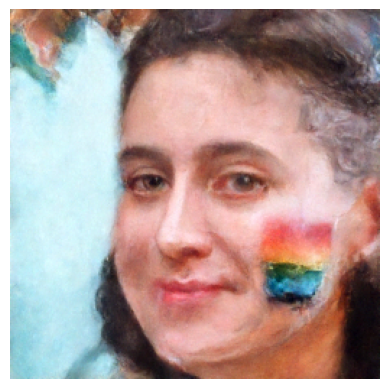

In [ ]:
import matplotlib.pyplot as plt
plt.imshow((x[0]/2+0.5).permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

## Experiment with Alarmire dataset

In [31]:
## create at diffusion model

model_config = dict(
            model_path=model_path,
            num_channels=128,
            num_res_blocks=1,
            attention_resolutions="16",
        ) if model_name == 'diffusion_ffhq_10m' \
        else dict(
            model_path=model_path,
            num_channels=256,
            num_res_blocks=2,
            attention_resolutions="8,16,32",
        )
args = utils_model.create_argparser(model_config).parse_args([])
model, diffusion = create_model_and_diffusion(
        **args_to_dict(args, model_and_diffusion_defaults().keys()))
    # model.load_state_dict(
    #     dist_util.load_state_dict(args.model_path, map_location="cpu")
    # )
model.load_state_dict(torch.load(args.model_path, map_location="cpu"))
model.eval()

if generate_mode != 'DPS_y0':
        # for DPS_yt, we can avoid backward through the model
    for k, v in model.named_parameters():
            v.requires_grad = False
model = model.to(device)

logger.info('model_name:{}, image sigma:{:.3f}, model sigma:{:.3f}'.format(model_name, noise_level_img, noise_level_model))
logger.info('eta:{:.3f}, zeta:{:.3f}, lambda:{:.3f}, guidance_scale:{:.2f} '.format(eta, zeta, lambda_, guidance_scale))
logger.info('start step:{}, skip_type:{}, skip interval:{}, skipstep analytic steps:{}'.format(t_start, skip_type, skip, noise_model_t))
logger.info('use_DIY_kernel:{}, blur mode:{}'.format(use_DIY_kernel, blur_mode))
logger.info('Model path: {:s}'.format(model_path))
logger.info(L_path)
L_paths = util.get_image_paths(L_path)

import ssl

if calc_LPIPS:
    import lpips

    # Disable SSL certificate verification
    ssl._create_default_https_context = ssl._create_unverified_context

    loss_fn_vgg = lpips.LPIPS(net='vgg').to(device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


In [32]:
## kernel predefine

for idx, img in enumerate(L_paths):
    if use_DIY_kernel:
        np.random.seed(seed=idx*10)  # for reproducibility of blur kernel for each image
        if blur_mode == 'Gaussian':
            kernel_std_i = kernel_std * np.abs(np.random.rand()*2+1)
            kernel = GaussialBlurOperator(kernel_size=kernel_size, intensity=kernel_std_i, device=device)
        elif blur_mode == 'motion':
            kernel = MotionBlurOperator(kernel_size=kernel_size, intensity=kernel_std, device=device)
        k_tensor = kernel.get_kernel().to(device, dtype=torch.float)
        k = k_tensor.clone().detach().cpu().numpy()       #[0,1]
        k = np.squeeze(k)
        k = np.squeeze(k)
    else:
        k_index = 0
        kernels = hdf5storage.loadmat(os.path.join(cwd, 'kernels', 'Levin09.mat'))['kernels']
        k = kernels[0, k_index].astype(np.float32)
    img_name, ext = os.path.splitext(os.path.basename(img))
    util.imsave(k*255.*200, os.path.join(E_path, f'motion_kernel_{img_name}{ext}'))
    #np.save(os.path.join(E_path, 'motion_kernel.npy'), k)
    k_4d = torch.from_numpy(k).to(device)
    k_4d = torch.einsum('ab,cd->abcd',torch.eye(3).to(device),k_4d)

    model_out_type = model_output_type

In [33]:
## Load image

img_H = util.imread_uint("/content/drive/MyDrive/tien/Capp.Sist.15_0089_fa_0043r_m.jpg", n_channels=n_channels)
img_H = util.modcrop(img_H, 8)
img_H.shape

(2712, 1936, 3)

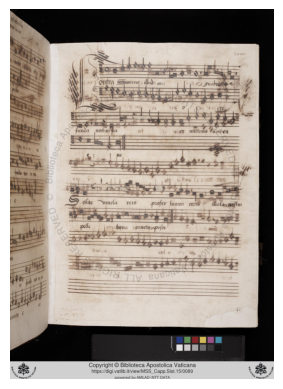

In [34]:
import matplotlib.pyplot as plt
import torch

# Display the image using matplotlib
plt.imshow(img_H)
plt.axis('off')  # Hide axis
plt.show()

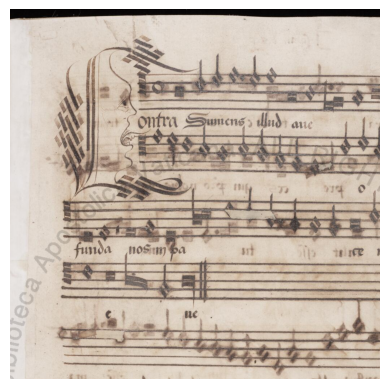

In [35]:
## crop a part of the whole image

left = 300
top = 226
right = 1324
bottom = 1250
crop_box = (left, top, right, bottom)

# Crop the image and show it
img_H = img_H[top:bottom, left:right]
# Resize the cropped image to 1024x1024
# resized_image = cropped_image.resize((1024, 1024))

# Display the resized image using matplotlib
plt.imshow(img_H)
plt.axis('off')  # Hide the axis
plt.show()

In [36]:
## Degrade image

img_L = ndimage.convolve(img_H, np.expand_dims(k, axis=2), mode='wrap')
util.imshow(img_H) if show_img else None
img_L = util.uint2single(img_L)

np.random.seed(seed=0)  # for reproducibility
img_L = img_L * 2 - 1
img_L += np.random.normal(0, noise_level_img * 2, img_L.shape) # add AWGN
img_L = img_L / 2 + 0.5

y = util.single2tensor4(img_L).to(device)

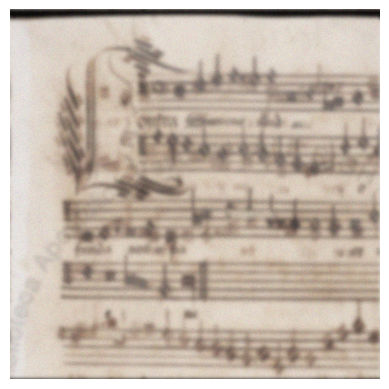

In [37]:
import matplotlib.pyplot as plt
import torch

# Display the image using matplotlib
plt.imshow(img_L)
plt.axis('off')  # Hide axis
plt.show()

In [38]:
# Calculate sigma, sigma_ks, rho (follow by t, pre-defined)
sigmas = []
sigma_ks = []
rhos = []
for i in range(num_train_timesteps):
    sigmas.append(reduced_alpha_cumprod[num_train_timesteps-1-i])
    if model_out_type == 'pred_xstart' and generate_mode == 'DiffPIR':
        sigma_ks.append((sqrt_1m_alphas_cumprod[i]/sqrt_alphas_cumprod[i]))
                #elif model_out_type == 'pred_x_prev':
    else:
        sigma_ks.append(torch.sqrt(betas[i]/alphas[i]))
    rhos.append(lambda_*(sigma**2)/(sigma_ks[i]**2))
rhos, sigmas, sigma_ks = torch.tensor(rhos).to(device), torch.tensor(sigmas).to(device), torch.tensor(sigma_ks).to(device)


t_y = utils_model.find_nearest(reduced_alpha_cumprod, 2 * noise_level_img)
sqrt_alpha_effective = sqrt_alphas_cumprod[t_start] / sqrt_alphas_cumprod[t_y]
x = sqrt_alpha_effective * (2*y-1) + torch.sqrt(sqrt_1m_alphas_cumprod[t_start]**2 - \
sqrt_alpha_effective**2 * sqrt_1m_alphas_cumprod[t_y]**2) * torch.randn_like(y)
# x = torch.randn_like(y)

k_tensor = util.single2tensor4(np.expand_dims(k, 2)).to(device)

In [39]:
progress_img = []
# create sequence of timestep for sampling
if skip_type == 'uniform':
    seq = [i*skip for i in range(iter_num)]
    if skip > 1:
        seq.append(num_train_timesteps-1)
elif skip_type == "quad":
    seq = np.sqrt(np.linspace(0, num_train_timesteps**2, iter_num))
    seq = [int(s) for s in list(seq)]
    seq[-1] = seq[-1] - 1
progress_seq = seq[::max(len(seq)//10,1)]
if progress_seq[-1] != seq[-1]:
    progress_seq.append(seq[-1])

In [40]:
FB, FBC, F2B, FBFy = sr.pre_calculate(y, k_tensor, sf)

In [41]:
## PnP algorithm


x = sqrt_alpha_effective * (2*y-1) + torch.sqrt(sqrt_1m_alphas_cumprod[t_start]**2 - \
                    sqrt_alpha_effective**2 * sqrt_1m_alphas_cumprod[t_y]**2) * torch.randn_like(y)

for i in range(len(seq)):
    curr_sigma = sigmas[seq[i]].cpu().numpy()
    # time step associated with the noise level sigmas[i]
    t_i = utils_model.find_nearest(reduced_alpha_cumprod,curr_sigma)

    x0 = utils_model.model_fn(x, noise_level=curr_sigma*255, model_out_type=model_out_type, \
                               model_diffusion=model, diffusion=diffusion, ddim_sample=ddim_sample, alphas_cumprod=alphas_cumprod)

    if seq[i] != seq[-1]:
       tau = rhos[t_i].float().repeat(1, 1, 1, 1)
       x0_p = x0 / 2 + 0.5
       x0_p = sr.data_solution(x0_p.float(), FB, FBC, F2B, FBFy, tau, sf)
       x0_p = x0_p * 2 - 1
       # effective x0
       x0 = x0 + guidance_scale * (x0_p-x0)
       t_im1 = utils_model.find_nearest(reduced_alpha_cumprod,sigmas[seq[i+1]].cpu().numpy())
       eps = (x - sqrt_alphas_cumprod[t_i] * x0) / sqrt_1m_alphas_cumprod[t_i]
       eta_sigma = eta * sqrt_1m_alphas_cumprod[t_im1] / sqrt_1m_alphas_cumprod[t_i] * torch.sqrt(betas[t_i])
       x = sqrt_alphas_cumprod[t_im1] * x0 + np.sqrt(1-zeta) * (torch.sqrt(sqrt_1m_alphas_cumprod[t_im1]**2 - eta_sigma**2) * eps \
            + eta_sigma * torch.randn_like(x)) + np.sqrt(zeta) * sqrt_1m_alphas_cumprod[t_im1] * torch.randn_like(x)

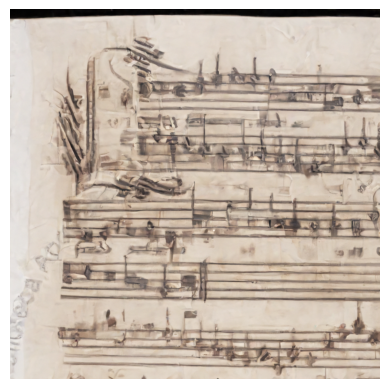

In [42]:
import matplotlib.pyplot as plt
plt.imshow((x[0]/2+0.5).permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

In [43]:
## Try to deblur the original data
y = util.single2tensor4(img_H).to(device)
FB, FBC, F2B, FBFy = sr.pre_calculate(y, k_tensor, sf)


x = sqrt_alpha_effective * (2*y-1) + torch.sqrt(sqrt_1m_alphas_cumprod[t_start]**2 - \
                    sqrt_alpha_effective**2 * sqrt_1m_alphas_cumprod[t_y]**2) * torch.randn_like(y)

for i in range(len(seq)):
    curr_sigma = sigmas[seq[i]].cpu().numpy()
    # time step associated with the noise level sigmas[i]
    t_i = utils_model.find_nearest(reduced_alpha_cumprod,curr_sigma)

    x0 = utils_model.model_fn(x, noise_level=curr_sigma*255, model_out_type=model_out_type, \
                               model_diffusion=model, diffusion=diffusion, ddim_sample=ddim_sample, alphas_cumprod=alphas_cumprod)

    if seq[i] != seq[-1]:
       tau = rhos[t_i].float().repeat(1, 1, 1, 1)
       x0_p = x0 / 2 + 0.5
       x0_p = sr.data_solution(x0_p.float(), FB, FBC, F2B, FBFy, tau, sf)
       x0_p = x0_p * 2 - 1
       # effective x0
       x0 = x0 + guidance_scale * (x0_p-x0)
       t_im1 = utils_model.find_nearest(reduced_alpha_cumprod,sigmas[seq[i+1]].cpu().numpy())
       eps = (x - sqrt_alphas_cumprod[t_i] * x0) / sqrt_1m_alphas_cumprod[t_i]
       eta_sigma = eta * sqrt_1m_alphas_cumprod[t_im1] / sqrt_1m_alphas_cumprod[t_i] * torch.sqrt(betas[t_i])
       x = sqrt_alphas_cumprod[t_im1] * x0 + np.sqrt(1-zeta) * (torch.sqrt(sqrt_1m_alphas_cumprod[t_im1]**2 - eta_sigma**2) * eps \
            + eta_sigma * torch.randn_like(x)) + np.sqrt(zeta) * sqrt_1m_alphas_cumprod[t_im1] * torch.randn_like(x)

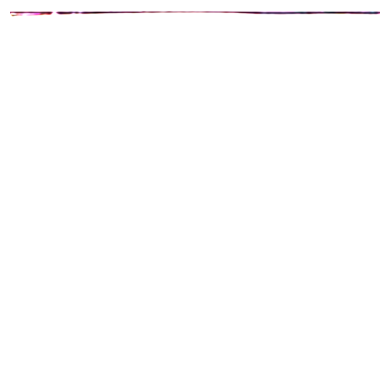

In [45]:
import matplotlib.pyplot as plt
plt.imshow((x[0]/2+0.5).permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

# Experiment inpaiting

## Original paper

In [55]:
## Import package
import os.path
import cv2
import logging

import numpy as np
import torch
from datetime import datetime
from collections import OrderedDict

from utils import utils_model
from utils import utils_logger
from utils import utils_image as util
from utils.utils_inpaint import mask_generator

# from guided_diffusion import dist_util
from guided_diffusion.script_util import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    create_model_and_diffusion,
    args_to_dict,
)

In [48]:
noise_level_img         = 0/255.0           # set AWGN noise level for LR image, default: 0
noise_level_model       = noise_level_img   # set noise level of model, default: 0
model_name              = 'diffusion_ffhq_10m'  # 256x256_diffusion_uncond, diffusion_ffhq_10m; set diffusino model
testset_name            = 'demo_test'        # set testing set, 'imagenet_val' | 'ffhq_val'
num_train_timesteps     = 1000
iter_num                = 20              # set number of iterations
iter_num_U              = 1                 # set number of inner iterations, default: 1
skip                    = num_train_timesteps//iter_num     # skip interval

mask_name               = 'gt_keep_masks/face/000000.png'   # mask path for loading mask img
load_mask               = False
mask_type               = 'random'  #['box', 'random', 'both', 'extreme']
mask_len_range          = [128, 129]
mask_prob_range         = [0.5, 0.5]

show_img                = False             # default: False
save_L                  = False             # save LR image
save_E                  = True              # save estimated image
save_LEH                = False             # save zoomed LR, E and H images
save_progressive        = False             # save generation process
save_progressive_mask   = False             # save generation process

sigma                   = max(0.001,noise_level_img)  # noise level associated with condition y
lambda_                 = 1.                # key parameter lambda
sub_1_analytic          = True              # use analytical solution
eta                     = 0.0               # eta for ddim samplingn
zeta                    = 1.0
guidance_scale          = 1.0

model_out_type          = 'pred_xstart'     # model output type: pred_x_prev; pred_xstart; epsilon; score
generate_mode           = 'DiffPIR'           # repaint; vanilla; DiffPIR
skip_type               = 'quad'            # uniform, quad
ddim_sample             = False             # sampling method

log_process             = False
task_current            = 'ip'              # 'ip' for inpainting
n_channels              = 3                 # fixed
cwd                     = ''
model_zoo               = os.path.join(cwd, 'model_zoo')    # fixed
testsets                = os.path.join(cwd, 'testsets')     # fixed
results                 = os.path.join(cwd, 'results')      # fixed
result_name             = f'{testset_name}_{task_current}_{generate_mode}_{mask_type}_{model_name}_sigma{noise_level_img}_NFE{iter_num}_eta{eta}_zeta{zeta}_lambda{lambda_}'
model_path              = '/content/drive/MyDrive/tien/models/ffhq_10m.pt'
device                  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

calc_LPIPS              = True

# noise schedule
beta_start              = 0.1 / 1000
beta_end                = 20 / 1000
betas                   = np.linspace(beta_start, beta_end, num_train_timesteps, dtype=np.float32)
betas                   = torch.from_numpy(betas).to(device)
alphas                  = 1.0 - betas
alphas_cumprod          = np.cumprod(alphas.cpu(), axis=0)
sqrt_alphas_cumprod     = torch.sqrt(alphas_cumprod)
sqrt_1m_alphas_cumprod  = torch.sqrt(1. - alphas_cumprod)
reduced_alpha_cumprod   = torch.div(sqrt_1m_alphas_cumprod, sqrt_alphas_cumprod)        # equivalent noise sigma on image

noise_model_t           = utils_model.find_nearest(reduced_alpha_cumprod, 2 * noise_level_model)
noise_model_t           = 0

noise_inti_img          = 50 / 255
t_start                 = utils_model.find_nearest(reduced_alpha_cumprod, 2 * noise_inti_img) # start timestep of the diffusion process
t_start                 = num_train_timesteps - 1

# ----------------------------------------
# L_path, E_path, H_path, mask_path
# ----------------------------------------

L_path                  = os.path.join(testsets, testset_name)      # L_path, for Low-quality images
E_path                  = os.path.join(results, result_name)        # E_path, for Estimated images
mask_path               = os.path.join(testsets, mask_name)         # mask_path, for mask images
util.mkdir(E_path)

logger_name             = result_name
utils_logger.logger_info(logger_name, log_path=os.path.join(E_path, logger_name+'.log'))
logger                  = logging.getLogger(logger_name)

LogHandlers exists!


In [49]:
model_config = dict(
            model_path=model_path,
            num_channels=128,
            num_res_blocks=1,
            attention_resolutions="16",
        ) if model_name == 'diffusion_ffhq_10m' \
        else dict(
            model_path=model_path,
            num_channels=256,
            num_res_blocks=2,
            attention_resolutions="8,16,32",
        )
args = utils_model.create_argparser(model_config).parse_args([])
model, diffusion = create_model_and_diffusion(
        **args_to_dict(args, model_and_diffusion_defaults().keys()))
    # model.load_state_dict(
    #     dist_util.load_state_dict(args.model_path, map_location="cpu")
    # )
model.load_state_dict(torch.load(args.model_path, map_location="cpu"))
model.eval()

if generate_mode != 'DPS_y0':
        # for DPS_yt, we can avoid backward through the model
    for k, v in model.named_parameters():
            v.requires_grad = False
model = model.to(device)

logger.info('model_name:{}, image sigma:{:.3f}, model sigma:{:.3f}'.format(model_name, noise_level_img, noise_level_model))
logger.info('eta:{:.3f}, zeta:{:.3f}, lambda:{:.3f}, guidance_scale:{:.2f} '.format(eta, zeta, lambda_, guidance_scale))
logger.info('start step:{}, skip_type:{}, skip interval:{}, skipstep analytic steps:{}'.format(t_start, skip_type, skip, noise_model_t))
logger.info('Model path: {:s}'.format(model_path))
logger.info(L_path)
L_paths = util.get_image_paths(L_path)

import ssl

if calc_LPIPS:
    import lpips

    # Disable SSL certificate verification
    ssl._create_default_https_context = ssl._create_unverified_context

    loss_fn_vgg = lpips.LPIPS(net='vgg').to(device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


In [50]:
device

device(type='cuda')

In [52]:
## Load image

img_H = util.imread_uint("/content/DiffPIR/testsets/demo_test/69037.png", n_channels=n_channels)
img_H = util.modcrop(img_H, 8)
img_H.shape

(256, 256, 3)

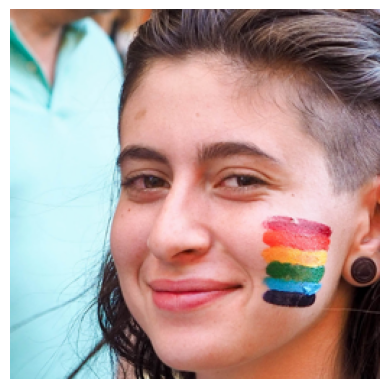

In [53]:
import matplotlib.pyplot as plt
import torch

# Display the image using matplotlib
plt.imshow(img_H)
plt.axis('off')  # Hide axis
plt.show()

In [59]:
## Degrade the image

mask_gen = mask_generator(mask_type=mask_type, mask_len_range=mask_len_range, mask_prob_range=mask_prob_range)
np.random.seed(seed=0)  # for reproducibility
mask = mask_gen(util.uint2tensor4(img_H)).numpy()
mask = np.squeeze(mask)
mask = np.transpose(mask, (1, 2, 0))

img_L = img_H * mask  / 255.

y = util.single2tensor4(img_L).to(device)   #(1,3,256,256)
y = y * 2 -1        # [-1,1]
mask = util.single2tensor4(mask.astype(np.float32)).to(device)

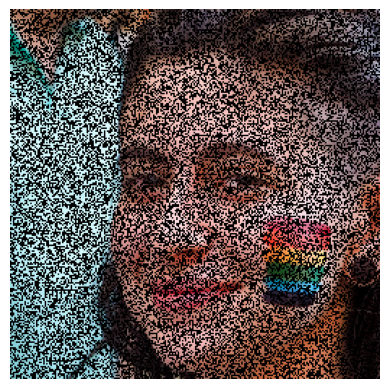

In [60]:
import matplotlib.pyplot as plt
import torch

# Display the image using matplotlib
plt.imshow(img_L)
plt.axis('off')  # Hide axis
plt.show()

In [61]:
## Define parameter for the algorithm

sigmas = []
sigma_ks = []
rhos = []
for i in range(num_train_timesteps):
    sigmas.append(reduced_alpha_cumprod[num_train_timesteps-1-i])
    if model_out_type == 'pred_xstart':
        sigma_ks.append((sqrt_1m_alphas_cumprod[i]/sqrt_alphas_cumprod[i]))
    elif model_out_type == 'pred_x_prev':
        sigma_ks.append(torch.sqrt(betas[i]/alphas[i]))
    rhos.append(lambda_*(sigma**2)/(sigma_ks[i]**2))

rhos, sigmas, sigma_ks = torch.tensor(rhos).to(device), torch.tensor(sigmas).to(device), torch.tensor(sigma_ks).to(device)

In [62]:
progress_img = []

seq = np.sqrt(np.linspace(0, num_train_timesteps**2, iter_num))
seq = [int(s) for s in list(seq)]
seq[-1] = seq[-1] - 1
progress_seq = seq[::(len(seq)//10)]
progress_seq.append(seq[-1])

In [63]:
## PnP algorithm

t_y = utils_model.find_nearest(reduced_alpha_cumprod, 2 * noise_level_img)
sqrt_alpha_effective = sqrt_alphas_cumprod[t_start] / sqrt_alphas_cumprod[t_y]
x = sqrt_alpha_effective * y + torch.sqrt(sqrt_1m_alphas_cumprod[t_start]**2 - \
    sqrt_alpha_effective**2 * sqrt_1m_alphas_cumprod[t_y]**2) * torch.randn_like(y)

for i in range(len(seq)):
    curr_sigma = sigmas[seq[i]].cpu().numpy()
    t_i = utils_model.find_nearest(reduced_alpha_cumprod,curr_sigma)
    x = (sqrt_alphas_cumprod[t_i] * y + sqrt_1m_alphas_cumprod[t_i] * torch.randn_like(x)) * mask \
            + (1-mask) * x


    x0 = utils_model.model_fn(x, noise_level=curr_sigma*255, model_out_type=model_out_type, \
                                model_diffusion=model, diffusion=diffusion, ddim_sample=ddim_sample, alphas_cumprod=alphas_cumprod)


    if seq[i] != seq[-1]:
        x0_p = (mask*y + rhos[t_i].float()*x0).div(mask+rhos[t_i])
        x0 = x0 + guidance_scale * (x0_p-x0)
        t_im1 = utils_model.find_nearest(reduced_alpha_cumprod,sigmas[seq[i+1]].cpu().numpy())
        eps = (x - sqrt_alphas_cumprod[t_i] * x0) / sqrt_1m_alphas_cumprod[t_i]
        eta_sigma = eta * sqrt_1m_alphas_cumprod[t_im1] / sqrt_1m_alphas_cumprod[t_i] * torch.sqrt(betas[t_i])
        x = sqrt_alphas_cumprod[t_im1] * x0 + np.sqrt(1-zeta) * (torch.sqrt(sqrt_1m_alphas_cumprod[t_im1]**2 - eta_sigma**2) * eps \
                                    + eta_sigma * torch.randn_like(x)) + np.sqrt(zeta) * sqrt_1m_alphas_cumprod[t_im1] * torch.randn_like(x)




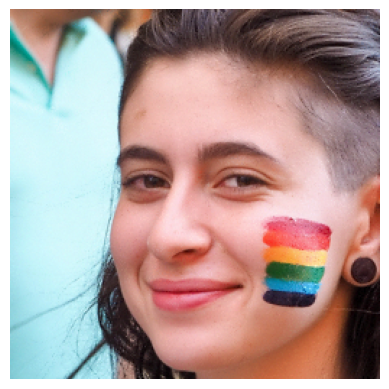

In [64]:
import matplotlib.pyplot as plt
plt.imshow((x[0]/2+0.5).permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

## Experiment with different defined mask

In [90]:
mask_gen = mask_generator(mask_type=mask_type, mask_len_range=[120, 200], mask_prob_range=[0.4, 0.2])
np.random.seed(seed=0)  # for reproducibility
mask = mask_gen(util.uint2tensor4(img_H)).numpy()
mask = np.squeeze(mask)
mask = np.transpose(mask, (1, 2, 0))

img_L_change = img_H * mask  / 255.
mask = util.single2tensor4(mask.astype(np.float32)).to(device)

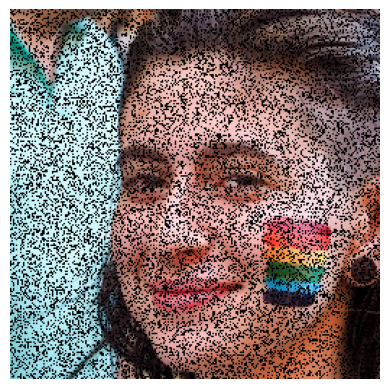

In [95]:
import matplotlib.pyplot as plt
import torch

# Display the image using matplotlib
plt.imshow(img_L_change)
plt.axis('off')  # Hide axis
plt.show()

In [91]:
## Define parameter for the algorithm

sigmas = []
sigma_ks = []
rhos = []
for i in range(num_train_timesteps):
    sigmas.append(reduced_alpha_cumprod[num_train_timesteps-1-i])
    if model_out_type == 'pred_xstart':
        sigma_ks.append((sqrt_1m_alphas_cumprod[i]/sqrt_alphas_cumprod[i]))
    elif model_out_type == 'pred_x_prev':
        sigma_ks.append(torch.sqrt(betas[i]/alphas[i]))
    rhos.append(lambda_*(sigma**2)/(sigma_ks[i]**2))

rhos, sigmas, sigma_ks = torch.tensor(rhos).to(device), torch.tensor(sigmas).to(device), torch.tensor(sigma_ks).to(device)

In [92]:
progress_img = []

seq = np.sqrt(np.linspace(0, num_train_timesteps**2, iter_num))
seq = [int(s) for s in list(seq)]
seq[-1] = seq[-1] - 1
progress_seq = seq[::(len(seq)//10)]
progress_seq.append(seq[-1])

In [93]:
## PnP algorithm

t_y = utils_model.find_nearest(reduced_alpha_cumprod, 2 * noise_level_img)
sqrt_alpha_effective = sqrt_alphas_cumprod[t_start] / sqrt_alphas_cumprod[t_y]
x = sqrt_alpha_effective * y + torch.sqrt(sqrt_1m_alphas_cumprod[t_start]**2 - \
    sqrt_alpha_effective**2 * sqrt_1m_alphas_cumprod[t_y]**2) * torch.randn_like(y)

for i in range(len(seq)):
    curr_sigma = sigmas[seq[i]].cpu().numpy()
    t_i = utils_model.find_nearest(reduced_alpha_cumprod,curr_sigma)
    x = (sqrt_alphas_cumprod[t_i] * y + sqrt_1m_alphas_cumprod[t_i] * torch.randn_like(x)) * mask \
            + (1-mask) * x


    x0 = utils_model.model_fn(x, noise_level=curr_sigma*255, model_out_type=model_out_type, \
                                model_diffusion=model, diffusion=diffusion, ddim_sample=ddim_sample, alphas_cumprod=alphas_cumprod)


    if seq[i] != seq[-1]:
        x0_p = (mask*y + rhos[t_i].float()*x0).div(mask+rhos[t_i])
        x0 = x0 + guidance_scale * (x0_p-x0)
        t_im1 = utils_model.find_nearest(reduced_alpha_cumprod,sigmas[seq[i+1]].cpu().numpy())
        eps = (x - sqrt_alphas_cumprod[t_i] * x0) / sqrt_1m_alphas_cumprod[t_i]
        eta_sigma = eta * sqrt_1m_alphas_cumprod[t_im1] / sqrt_1m_alphas_cumprod[t_i] * torch.sqrt(betas[t_i])
        x = sqrt_alphas_cumprod[t_im1] * x0 + np.sqrt(1-zeta) * (torch.sqrt(sqrt_1m_alphas_cumprod[t_im1]**2 - eta_sigma**2) * eps \
                                    + eta_sigma * torch.randn_like(x)) + np.sqrt(zeta) * sqrt_1m_alphas_cumprod[t_im1] * torch.randn_like(x)



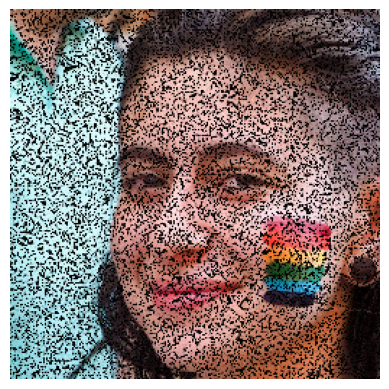

In [94]:
import matplotlib.pyplot as plt
plt.imshow((x[0]/2+0.5).permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

## Experiment with different diffusion model

In [111]:
## create another model

model_config = dict(
            model_path='/content/drive/MyDrive/tien/models/metface_p2.pt',
            num_channels=128,
            num_res_blocks=1,
            attention_resolutions="16",
        ) if model_name == 'diffusion_ffhq_10m' \
        else dict(
            model_path='/content/drive/MyDrive/tien/models/metface_p2.pt',
            num_channels=256,
            num_res_blocks=2,
            attention_resolutions="8,16,32",
        )
args = utils_model.create_argparser(model_config).parse_args([])
model, diffusion = create_model_and_diffusion(
        **args_to_dict(args, model_and_diffusion_defaults().keys()))
    # model.load_state_dict(
    #     dist_util.load_state_dict(args.model_path, map_location="cpu")
    # )
model.load_state_dict(torch.load(args.model_path, map_location="cpu"))
model.eval()

if generate_mode != 'DPS_y0':
        # for DPS_yt, we can avoid backward through the model
    for k, v in model.named_parameters():
            v.requires_grad = False
model = model.to(device)

logger.info('model_name:{}, image sigma:{:.3f}, model sigma:{:.3f}'.format(model_name, noise_level_img, noise_level_model))
logger.info('eta:{:.3f}, zeta:{:.3f}, lambda:{:.3f}, guidance_scale:{:.2f} '.format(eta, zeta, lambda_, guidance_scale))
logger.info('start step:{}, skip_type:{}, skip interval:{}, skipstep analytic steps:{}'.format(t_start, skip_type, skip, noise_model_t))
logger.info('Model path: {:s}'.format(model_path))
logger.info(L_path)
L_paths = util.get_image_paths(L_path)

import ssl

if calc_LPIPS:
    import lpips

    # Disable SSL certificate verification
    ssl._create_default_https_context = ssl._create_unverified_context

    loss_fn_vgg = lpips.LPIPS(net='vgg').to(device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


In [112]:
## Degrade the image

mask_gen = mask_generator(mask_type=mask_type, mask_len_range=mask_len_range, mask_prob_range=mask_prob_range)
np.random.seed(seed=0)  # for reproducibility
mask = mask_gen(util.uint2tensor4(img_H)).numpy()
mask = np.squeeze(mask)
mask = np.transpose(mask, (1, 2, 0))

img_L = img_H * mask  / 255.

y = util.single2tensor4(img_L).to(device)   #(1,3,256,256)
y = y * 2 -1        # [-1,1]
mask = util.single2tensor4(mask.astype(np.float32)).to(device)

In [113]:
## Define parameter for the algorithm

sigmas = []
sigma_ks = []
rhos = []
for i in range(num_train_timesteps):
    sigmas.append(reduced_alpha_cumprod[num_train_timesteps-1-i])
    if model_out_type == 'pred_xstart':
        sigma_ks.append((sqrt_1m_alphas_cumprod[i]/sqrt_alphas_cumprod[i]))
    elif model_out_type == 'pred_x_prev':
        sigma_ks.append(torch.sqrt(betas[i]/alphas[i]))
    rhos.append(lambda_*(sigma**2)/(sigma_ks[i]**2))

rhos, sigmas, sigma_ks = torch.tensor(rhos).to(device), torch.tensor(sigmas).to(device), torch.tensor(sigma_ks).to(device)

In [114]:
progress_img = []

seq = np.sqrt(np.linspace(0, num_train_timesteps**2, iter_num))
seq = [int(s) for s in list(seq)]
seq[-1] = seq[-1] - 1
progress_seq = seq[::(len(seq)//10)]
progress_seq.append(seq[-1])

In [115]:
## PnP algorithm

t_y = utils_model.find_nearest(reduced_alpha_cumprod, 2 * noise_level_img)
sqrt_alpha_effective = sqrt_alphas_cumprod[t_start] / sqrt_alphas_cumprod[t_y]
x = sqrt_alpha_effective * y + torch.sqrt(sqrt_1m_alphas_cumprod[t_start]**2 - \
    sqrt_alpha_effective**2 * sqrt_1m_alphas_cumprod[t_y]**2) * torch.randn_like(y)

for i in range(len(seq)):
    curr_sigma = sigmas[seq[i]].cpu().numpy()
    t_i = utils_model.find_nearest(reduced_alpha_cumprod,curr_sigma)
    x = (sqrt_alphas_cumprod[t_i] * y + sqrt_1m_alphas_cumprod[t_i] * torch.randn_like(x)) * mask \
            + (1-mask) * x


    x0 = utils_model.model_fn(x, noise_level=curr_sigma*255, model_out_type=model_out_type, \
                                model_diffusion=model, diffusion=diffusion, ddim_sample=ddim_sample, alphas_cumprod=alphas_cumprod)


    if seq[i] != seq[-1]:
        x0_p = (mask*y + rhos[t_i].float()*x0).div(mask+rhos[t_i])
        x0 = x0 + guidance_scale * (x0_p-x0)
        t_im1 = utils_model.find_nearest(reduced_alpha_cumprod,sigmas[seq[i+1]].cpu().numpy())
        eps = (x - sqrt_alphas_cumprod[t_i] * x0) / sqrt_1m_alphas_cumprod[t_i]
        eta_sigma = eta * sqrt_1m_alphas_cumprod[t_im1] / sqrt_1m_alphas_cumprod[t_i] * torch.sqrt(betas[t_i])
        x = sqrt_alphas_cumprod[t_im1] * x0 + np.sqrt(1-zeta) * (torch.sqrt(sqrt_1m_alphas_cumprod[t_im1]**2 - eta_sigma**2) * eps \
                                    + eta_sigma * torch.randn_like(x)) + np.sqrt(zeta) * sqrt_1m_alphas_cumprod[t_im1] * torch.randn_like(x)


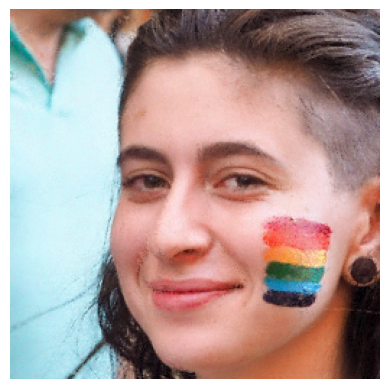

In [116]:
import matplotlib.pyplot as plt
plt.imshow((x[0]/2+0.5).permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

## Experiment with Alarmire dataset

In [117]:
## create model

model_config = dict(
            model_path=model_path,
            num_channels=128,
            num_res_blocks=1,
            attention_resolutions="16",
        ) if model_name == 'diffusion_ffhq_10m' \
        else dict(
            model_path=model_path,
            num_channels=256,
            num_res_blocks=2,
            attention_resolutions="8,16,32",
        )
args = utils_model.create_argparser(model_config).parse_args([])
model, diffusion = create_model_and_diffusion(
        **args_to_dict(args, model_and_diffusion_defaults().keys()))
    # model.load_state_dict(
    #     dist_util.load_state_dict(args.model_path, map_location="cpu")
    # )
model.load_state_dict(torch.load(args.model_path, map_location="cpu"))
model.eval()

if generate_mode != 'DPS_y0':
        # for DPS_yt, we can avoid backward through the model
    for k, v in model.named_parameters():
            v.requires_grad = False
model = model.to(device)

logger.info('model_name:{}, image sigma:{:.3f}, model sigma:{:.3f}'.format(model_name, noise_level_img, noise_level_model))
logger.info('eta:{:.3f}, zeta:{:.3f}, lambda:{:.3f}, guidance_scale:{:.2f} '.format(eta, zeta, lambda_, guidance_scale))
logger.info('start step:{}, skip_type:{}, skip interval:{}, skipstep analytic steps:{}'.format(t_start, skip_type, skip, noise_model_t))
logger.info('Model path: {:s}'.format(model_path))
logger.info(L_path)
L_paths = util.get_image_paths(L_path)

import ssl

if calc_LPIPS:
    import lpips

    # Disable SSL certificate verification
    ssl._create_default_https_context = ssl._create_unverified_context

    loss_fn_vgg = lpips.LPIPS(net='vgg').to(device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


In [121]:
## Load image

img_H = util.imread_uint("/content/drive/MyDrive/tien/Capp.Sist.15_0089_fa_0043r_m.jpg", n_channels=n_channels)
img_H = util.modcrop(img_H, 8)
img_H.shape

(2712, 1936, 3)

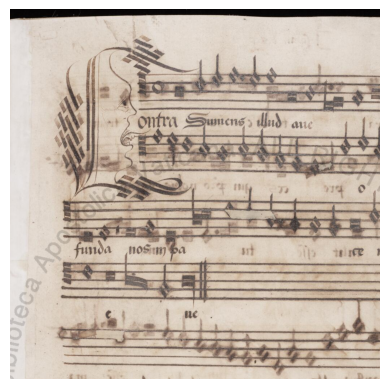

In [122]:
## crop a part of the whole image

left = 300
top = 226
right = 1324
bottom = 1250
crop_box = (left, top, right, bottom)

# Crop the image and show it
img_H = img_H[top:bottom, left:right]
# Resize the cropped image to 1024x1024
# resized_image = cropped_image.resize((1024, 1024))

# Display the resized image using matplotlib
plt.imshow(img_H)
plt.axis('off')  # Hide the axis
plt.show()

In [130]:
## Degrade the image

mask_gen = mask_generator(mask_type=mask_type, mask_len_range=mask_len_range, mask_prob_range=mask_prob_range, image_size=1024)
np.random.seed(seed=0)  # for reproducibility
mask = mask_gen(util.uint2tensor4(img_H)).numpy()
mask = np.squeeze(mask)
mask = np.transpose(mask, (1, 2, 0))

img_L = img_H * mask  / 255.

y = util.single2tensor4(img_L).to(device)   #(1,3,256,256)
y = y * 2 -1        # [-1,1]
mask = util.single2tensor4(mask.astype(np.float32)).to(device)

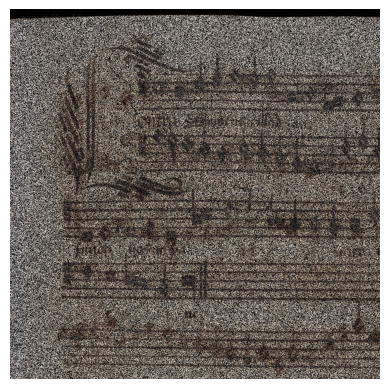

In [131]:
import matplotlib.pyplot as plt
import torch

# Display the image using matplotlib
plt.imshow(img_L)
plt.axis('off')  # Hide axis
plt.show()

In [132]:
## Define parameter for the algorithm

sigmas = []
sigma_ks = []
rhos = []
for i in range(num_train_timesteps):
    sigmas.append(reduced_alpha_cumprod[num_train_timesteps-1-i])
    if model_out_type == 'pred_xstart':
        sigma_ks.append((sqrt_1m_alphas_cumprod[i]/sqrt_alphas_cumprod[i]))
    elif model_out_type == 'pred_x_prev':
        sigma_ks.append(torch.sqrt(betas[i]/alphas[i]))
    rhos.append(lambda_*(sigma**2)/(sigma_ks[i]**2))

rhos, sigmas, sigma_ks = torch.tensor(rhos).to(device), torch.tensor(sigmas).to(device), torch.tensor(sigma_ks).to(device)

In [133]:
progress_img = []

seq = np.sqrt(np.linspace(0, num_train_timesteps**2, iter_num))
seq = [int(s) for s in list(seq)]
seq[-1] = seq[-1] - 1
progress_seq = seq[::(len(seq)//10)]
progress_seq.append(seq[-1])

In [134]:
## PnP algorithm

t_y = utils_model.find_nearest(reduced_alpha_cumprod, 2 * noise_level_img)
sqrt_alpha_effective = sqrt_alphas_cumprod[t_start] / sqrt_alphas_cumprod[t_y]
x = sqrt_alpha_effective * y + torch.sqrt(sqrt_1m_alphas_cumprod[t_start]**2 - \
    sqrt_alpha_effective**2 * sqrt_1m_alphas_cumprod[t_y]**2) * torch.randn_like(y)

for i in range(len(seq)):
    curr_sigma = sigmas[seq[i]].cpu().numpy()
    t_i = utils_model.find_nearest(reduced_alpha_cumprod,curr_sigma)
    x = (sqrt_alphas_cumprod[t_i] * y + sqrt_1m_alphas_cumprod[t_i] * torch.randn_like(x)) * mask \
            + (1-mask) * x


    x0 = utils_model.model_fn(x, noise_level=curr_sigma*255, model_out_type=model_out_type, \
                                model_diffusion=model, diffusion=diffusion, ddim_sample=ddim_sample, alphas_cumprod=alphas_cumprod)


    if seq[i] != seq[-1]:
        x0_p = (mask*y + rhos[t_i].float()*x0).div(mask+rhos[t_i])
        x0 = x0 + guidance_scale * (x0_p-x0)
        t_im1 = utils_model.find_nearest(reduced_alpha_cumprod,sigmas[seq[i+1]].cpu().numpy())
        eps = (x - sqrt_alphas_cumprod[t_i] * x0) / sqrt_1m_alphas_cumprod[t_i]
        eta_sigma = eta * sqrt_1m_alphas_cumprod[t_im1] / sqrt_1m_alphas_cumprod[t_i] * torch.sqrt(betas[t_i])
        x = sqrt_alphas_cumprod[t_im1] * x0 + np.sqrt(1-zeta) * (torch.sqrt(sqrt_1m_alphas_cumprod[t_im1]**2 - eta_sigma**2) * eps \
                                    + eta_sigma * torch.randn_like(x)) + np.sqrt(zeta) * sqrt_1m_alphas_cumprod[t_im1] * torch.randn_like(x)

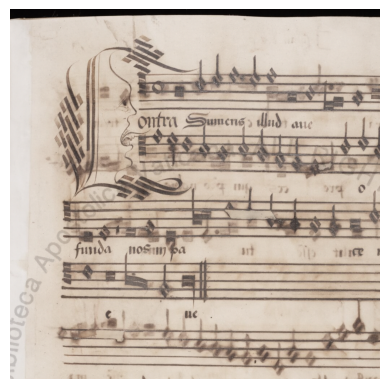

In [135]:
import matplotlib.pyplot as plt
plt.imshow((x[0]/2+0.5).permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

## Experiment with the original alamire image

In [136]:
y = util.single2tensor4(img_H).to(device)   #(1,3,256,256)
y = y * 2 -1        # [-1,1]


In [137]:
## PnP algorithm

t_y = utils_model.find_nearest(reduced_alpha_cumprod, 2 * noise_level_img)
sqrt_alpha_effective = sqrt_alphas_cumprod[t_start] / sqrt_alphas_cumprod[t_y]
x = sqrt_alpha_effective * y + torch.sqrt(sqrt_1m_alphas_cumprod[t_start]**2 - \
    sqrt_alpha_effective**2 * sqrt_1m_alphas_cumprod[t_y]**2) * torch.randn_like(y)

for i in range(len(seq)):
    curr_sigma = sigmas[seq[i]].cpu().numpy()
    t_i = utils_model.find_nearest(reduced_alpha_cumprod,curr_sigma)
    x = (sqrt_alphas_cumprod[t_i] * y + sqrt_1m_alphas_cumprod[t_i] * torch.randn_like(x)) * mask \
            + (1-mask) * x


    x0 = utils_model.model_fn(x, noise_level=curr_sigma*255, model_out_type=model_out_type, \
                                model_diffusion=model, diffusion=diffusion, ddim_sample=ddim_sample, alphas_cumprod=alphas_cumprod)


    if seq[i] != seq[-1]:
        x0_p = (mask*y + rhos[t_i].float()*x0).div(mask+rhos[t_i])
        x0 = x0 + guidance_scale * (x0_p-x0)
        t_im1 = utils_model.find_nearest(reduced_alpha_cumprod,sigmas[seq[i+1]].cpu().numpy())
        eps = (x - sqrt_alphas_cumprod[t_i] * x0) / sqrt_1m_alphas_cumprod[t_i]
        eta_sigma = eta * sqrt_1m_alphas_cumprod[t_im1] / sqrt_1m_alphas_cumprod[t_i] * torch.sqrt(betas[t_i])
        x = sqrt_alphas_cumprod[t_im1] * x0 + np.sqrt(1-zeta) * (torch.sqrt(sqrt_1m_alphas_cumprod[t_im1]**2 - eta_sigma**2) * eps \
                                    + eta_sigma * torch.randn_like(x)) + np.sqrt(zeta) * sqrt_1m_alphas_cumprod[t_im1] * torch.randn_like(x)

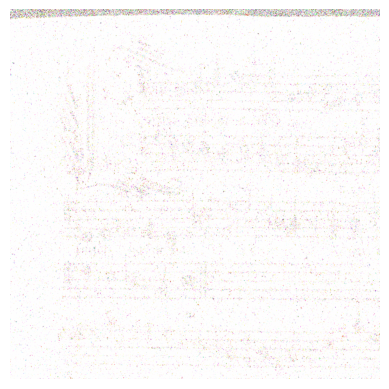

In [138]:
import matplotlib.pyplot as plt
plt.imshow((x[0]/2+0.5).permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()